# A simple model

Let's take a simplified version of the model described in the text, one with atmospheric, terrestrial and ocean carbon. 

| Reservoir   | Initial amount (Gt) |
|-------------|---------------------|
| Atmosphere  | 750                 |
| Terrestrial | 600                 |
| Ocean       | 1000                |

And let's use the following major fluxes:

| Flux                            | Rate (Gt C/yr) | Source      | Sink        |
|---------------------------------|----------------|-------------|-------------|
| Terrestrial Photosynthesis      | 110            | Atmosphere  | Terrestrial |
| Marine Photosynthesis           | 40             | Atmosphere  | Ocean       |
| People dumping trash into ocean | 110            | Terrestrial | Ocean       |
| Marine Respiration              | 150            | Ocean       | Atmosphere  |

With that in mind, we could make a completely stable, unchanging model

In [1]:
import numpy as np, matplotlib as mpl, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

/Users/mglerner/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


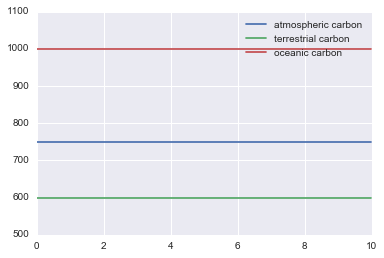

In [2]:
atmos, terrestrial, ocean = 750, 600, 1000
a_t, a_o, t_o, o_a = 110, 40, 110, 150

time = 0
dt = 0.01

def evolve_system(time,dt,atmos,terrestrial,ocean,a_t,a_o,t_o,o_a):
    atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
    return atmos, terrestrial, ocean

system_state = []
for step in range(1000):
    time = time + dt
    atmos, terrestrial, ocean = evolve_system(time,dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
    system_state.append((time,atmos,terrestrial,ocean))

time = [i[0] for i in system_state]
atmos = [i[1] for i in system_state]
terrestrial = [i[2] for i in system_state]
ocean = [i[3] for i in system_state]

plt.plot(time,atmos,label='atmospheric carbon')
plt.plot(time,terrestrial,label='terrestrial carbon')
plt.plot(time,ocean,label='oceanic carbon')
plt.ylim([500,1100])
plt.legend()

So, not very exciting. But that's because we're doing it wrong. The rates given above are *initial* rates. You should recall from the reading (and from your own thought process) that the rate of carbon flow from, e.g., the atmosphere to the ocean depends on how much carbon is in the atmosphere to begin with. If there's more carbon in the atmosphere, more carbon will flow to the ocean. That is, you might imagine that more Gt of carbon will flow to from the atmosphere to the ocean if we have 70000 Gt of carbon in the atmosphere than if we have 20 Gt C.

Let's put this back into the language of mathematics. The model we plotted above looks like

$\frac{dA}{dt} = -110 - 40 + 150\\
\frac{dT}{dt} = -100 + 110\\
\frac{dO}{dt} = -150 + 40 + 110
$

Followed by a simple update

$A_{i+1} = A_{i} + \Delta t * \frac{dA}{dt}\\
...
$

Those rates are constant. But, as we just discussed, we really want those rates to depend on the amount of carbon in the various reservoirs. You might also get a clue that it's wrong because my above code didn't actually care what $\Delta t$ was.

So, if we want our model to care about flow between the reservoirs properly, let's think about those rates. Instead of saying `terrestrial photosynthesis = 110` let's say `terrestrial photosynthesis = terrestrial_carbon * terrestrial_photosynthesis_rate`, etc. Then our model might look like (recalling our tables):

| Reservoir   | Initial amount (Gt) |
|-------------|---------------------|
| Atmosphere  | 750                 |
| Terrestrial | 600                 |
| Ocean       | 1000                |

And let's use the following major fluxes:

| Flux                            | Rate (Gt C/yr) | Source      | Sink        |
|---------------------------------|----------------|-------------|-------------|
| Terrestrial Photosynthesis      | 110            | Atmosphere  | Terrestrial |
| Marine Photosynthesis           | 40             | Atmosphere  | Ocean       |
| People dumping trash into ocean | 110            | Terrestrial | Ocean       |
| Marine Respiration              | 150            | Ocean       | Atmosphere  |


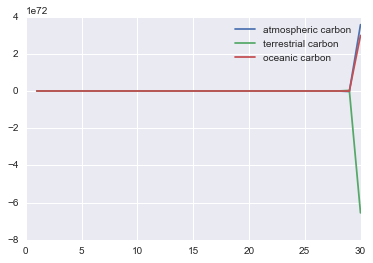

In [3]:
atmos, terrestrial, ocean = 750, 600, 1000
a_t_rate, a_o_rate, t_o_rate, o_a_rate = 110/750, 40/750, 110/600, 150/1000

time = 0
dt = 1 # This is in years, based on what I've done above. You want dt in something smaller than years. How do you handle that?

def evolve_system(dt,atmos,terrestrial,ocean,a_t_rate,a_o_rate,t_o_rate,o_a_rate):
    a_t = a_t_rate * atmos * dt
    a_o = a_o_rate * atmos * dt
    t_o = t_o_rate * terrestrial * dt
    o_a = o_a_rate * ocean * dt
    atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
    return atmos, terrestrial, ocean

system_state = []
for step in range(30):
    time = time + dt
    atmos, terrestrial, ocean = evolve_system(dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
    system_state.append((time,atmos,terrestrial,ocean))

time = [i[0] for i in system_state]
atmos = [i[1] for i in system_state]
terrestrial = [i[2] for i in system_state]
ocean = [i[3] for i in system_state]

plt.plot(time,atmos,label='atmospheric carbon')
plt.plot(time,terrestrial,label='terrestrial carbon')
plt.plot(time,ocean,label='oceanic carbon')
#plt.ylim([500,1100])
plt.legend()

Now, as you can see above, things are certainly not constant. Part of the problem is that you have a horribly long timestep. Part of the problem is that you're using a crummy integrator. Here's what happens for me when I fix the timestep:

In [4]:
def plotit(dt):
    atmos, terrestrial, ocean = 750, 600, 1000
    a_t_rate, a_o_rate, t_o_rate, o_a_rate = dt*0.147, dt*0.053, dt*0.183, dt*0.15

    time = 0

    def evolve_system(dt,atmos,terrestrial,ocean,a_t_rate,a_o_rate,t_o_rate,o_a_rate):
        a_t = a_t_rate * atmos * dt
        a_o = a_o_rate * atmos * dt
        t_o = t_o_rate * terrestrial * dt
        o_a = o_a_rate * ocean * dt
        atmos, terrestrial, ocean = atmos - a_t - a_o + o_a, terrestrial - t_o + a_t, ocean - o_a + a_o + t_o
        return atmos, terrestrial, ocean

    system_state = []
    for step in range(300):
        time = time + dt
        atmos, terrestrial, ocean = evolve_system(dt,atmos,terrestrial,ocean,a_t, a_o, t_o, o_a)
        system_state.append((time,atmos,terrestrial,ocean))

    time = [i[0] for i in system_state]
    atmos = [i[1] for i in system_state]
    terrestrial = [i[2] for i in system_state]
    ocean = [i[3] for i in system_state]

    plt.plot(time,atmos,label='atmospheric carbon')
    plt.plot(time,terrestrial,label='terrestrial carbon')
    plt.plot(time,ocean,label='oceanic carbon')
    #plt.ylim([500,1100])
    plt.legend()

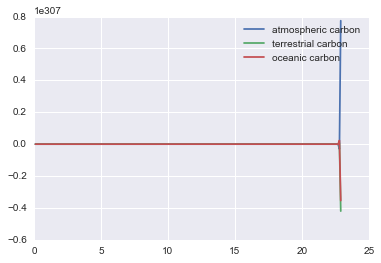

In [5]:
plotit(dt=.1)

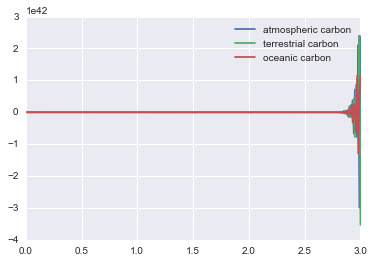

In [6]:
plotit(dt=.01)

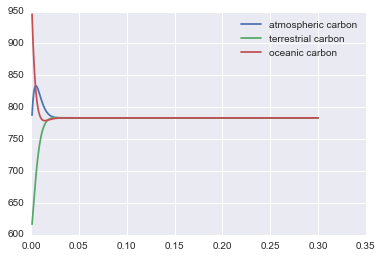

In [7]:
plotit(dt=.001)

So, that should give you enough to get started. Remember, 

* your model is more complex than the one above. So, hopefully, it has a more interesting final behavior.
* Don't forget to try to find a way to use a better integrator. You can feel free to use one of the functions from `scipy` or to google for Runge-Kutta 4 in Python.
* Also don't forget the sentence "Assume that the rate of change of marine materials sinking to the deep ocean is constant, but in all other cases, assume that the rate of car- bon transfer from source to sink is proportional to the amount of carbon in the source."
* "Another sentence worth noting is "Carbon dioxide gas exchange between the atmosphere and the ocean surface, which involves gas dissolving into and evaporating from water, is in the direction of greater to lesser carbon concentration."


(Quotes from B., Shiflet, A., Shiflet, W.. Introduction to Computational Science: Modeling and Simulation for the Sciences,  2nd Edition. Princeton University Press, 03/2014. VitalBook file.)

# What about the y-axis

In the "real" application, you'll find that some values are much higher than others. Enough so that you have a hard time looking at all of them on the same plot. Here's an example:

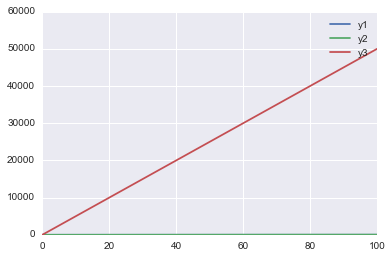

In [9]:
x = np.linspace(0,100,1000)
y1 = 0.2*x + np.random.rand(1000)
y2 = 0.4*x + np.random.rand(1000)
y3 = 500*x + np.random.rand(1000)
plt.plot(x,y1,label='y1')
plt.plot(x,y2,label='y2')
plt.plot(x,y3,label='y3')
plt.legend()

Oops. Nobody can tell what's happening with y1 and y2. Here's how you can split off two y axes, and plot them separately. Note that you have to ask the axis objects (ax1, ax2) to plot things separately

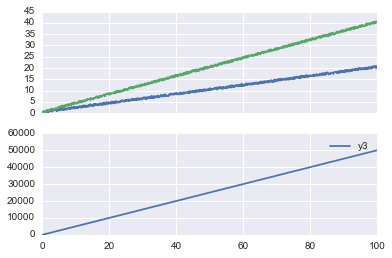

In [11]:
x = np.linspace(0,100,1000)
y1 = 0.2*x + np.random.rand(1000)
y2 = 0.4*x + np.random.rand(1000)
y3 = 500*x + np.random.rand(1000)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(x,y1,label='y1')
ax1.plot(x,y2,label='y2')
ax2.plot(x,y3,label='y3')
plt.legend()

Well, two problems: 
1. the legend only showed up on the bottom
2. the colors are repeated
3. the small things are on top. that's because the "first" axis is always on the bottom.

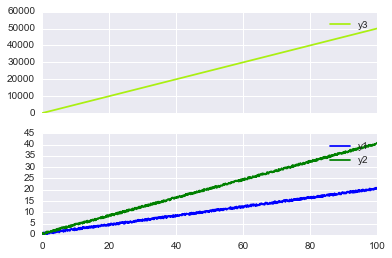

In [16]:
x = np.linspace(0,100,1000)
y1 = 0.2*x + np.random.rand(1000)
y2 = 0.4*x + np.random.rand(1000)
y3 = 500*x + np.random.rand(1000)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax2.plot(x,y1,label='y1',color='blue')
ax2.plot(x,y2,label='y2',color='green')
ax1.plot(x,y3,label='y3',color='#aaef12')
ax1.legend()
ax2.legend()

# Using a better numerical method

The project tells you to use Runge-Kutta 4, or some similar algorithm. You should. I'll describe how to use one of the standard numerical integrators built into SciPy. Let's use it to look at the simple model presented above. The key thing you need to realize is that these methods expect you to feed them a function that returns a matrix of *derivatives*. So, instead of making an `evolve_system` function that does things like

```python
a_t = a_t_rate * atmos * dt
...
atmos = atmos - a_t - a_o + o_a
...
return (atmos, terrestrial, ocean)
```

We'll want to just return the derivatives. Here's an example



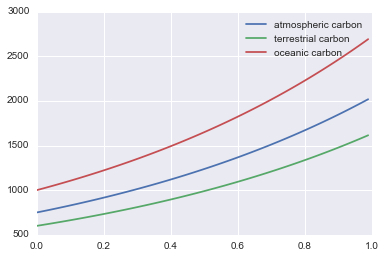

In [23]:
dt = 0.01
atmos0, terrestrial0, ocean0 = 750, 600, 1000
a_t_rate, a_o_rate, t_o_rate, o_a_rate = dt*0.147, dt*0.053, dt*0.183, dt*0.15

from scipy import integrate

def simplemodel():
    # We make a vector X containing [atmos, terrestrial, ocean]
    # Here are our initial values
    init = [atmos0,terrestrial0,ocean0]
    def derivX(X,t):
        # Note that we have to take in `t` as a parameter, even though we don't use it.
        atmos, terrestrial, ocean = X
        a_t = a_t_rate * atmos
        a_o = a_o_rate * atmos
        t_o = t_o_rate * terrestrial
        o_a = o_a_rate * ocean
        # Just the derivatives here. Compare to the previous code!
        datmos = - a_t - a_o + o_a
        dterrestrial = - t_o + a_t
        docean = - o_a + a_o + t_o
        return np.array([atmos, terrestrial, ocean])

    # Look up the difference between np.arange and np.linspace
    time = np.arange(0,1,dt) 

    # Let scipy.integrate.odeint do all the work for us!
    X = integrate.odeint(derivX,init,time)
    atmos, terrestrial, ocean = X[:,0], X[:,1], X[:,2]

    plt.plot(time,atmos,label='atmospheric carbon')
    plt.plot(time,terrestrial,label='terrestrial carbon')
    plt.plot(time,ocean,label='oceanic carbon')
    plt.legend()
simplemodel()

# But that looks crazy

Yup. The underlying model is bad. But this should be enough to get you started. REMEMBER THAT YOU NEED TO PASS ALONG THE DERIVATIVES!